# Creating FDTD animations in Tidy3D

Animations are often created from FDTD simulations to provide a more intuitive understanding of the physical phenomena being modeled. These animations can visualize the evolution of the field distribution over time, showing wave propagation, interactions, and other dynamic effects that static images cannot adequately depict. This can help researchers and engineers better understand the results of their simulations, identify anomalies, and develop or refine their models. Additionally, these animations can serve as effective educational and communication tools, making complex concepts more accessible to non-experts.

This tutorial demonstrates how to create an animation in a waveguide taper simulation and display the animation directly in a Jupyter Notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import tidy3d as td
import tidy3d.web as web


## Simulation Setup

For this demo, we simply simulate a linear waveguide taper. The simulation setup is directly borrowed from the [waveguide size converter](../notebooks/WaveguideSizeConverter.html) case study notebook.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the frequency distribution


In [3]:
n_si = 3.48  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)


In [4]:
w_in = 5  # input waveguide width
w_out = 0.45  # output waveguide width
t_wg = 0.11  # waveguide thickness
L_t = 10
inf_eff = 1e3  # effective infinity of the model

# define the substrate structure
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
    ),
    medium=sio2,
)

# vertices of the taper
vertices = [
    [-inf_eff, w_in / 2],
    [0, w_in / 2],
    [L_t, w_out / 2],
    [inf_eff, w_out / 2],
    [inf_eff, -w_out / 2],
    [L_t, -w_out / 2],
    [0, -w_in / 2],
    [-inf_eff, -w_in / 2],
]

# construct the taper structure using a PolySlab
linear_taper = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_wg)),
    medium=si,
)


To create an animation, we need to capture the frames at different time instances of the simulation. This can be done by using a [FieldTimeMonitor](../_autosummary/tidy3d.FieldTimeMonitor.html). Usually a FDTD simulation contains a large number of time steps and grid points. Recording the field at every time step and grid point will result in a large dataset. For the purpose of making animations, this is usually unnecessary. In this particular case, we will record one frame every 100 time steps, which is realized by setting `interval=100` in the [FieldTimeMonitor](../_autosummary/tidy3d.FieldTimeMonitor.html). Similarly, we set `interval_space=(3,3,1)` such that the field is recorded every 3 grid points. To further reduce dataset size, we will only be recording the z-component of the magnetic field. 

In [5]:
run_time = 5e-13  # run time of the simulation

# define a mode source
mode_source = td.ModeSource(
    center=(-lda0 / 2, 0, t_wg / 2),
    size=(0, 1.2 * w_in, 6 * t_wg),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# define a field time monitor to record animation frames
monitor = td.FieldTimeMonitor(
    center=(0, 0, t_wg/2),
    size=(td.inf, td.inf, 0),
    fields=['Hz'],
    start=0,
    stop=run_time,
    interval=100,
    interval_space=(3,3,1),
    name='movie_monitor'
)

# define simulation domain size
Lx = L_t + 2 * lda0
Ly = w_in + 2 * lda0
Lz = t_wg + 1.5 * lda0
sim_size = (Lx, Ly, Lz)

# define simulation
sim = td.Simulation(
    center=(L_t / 2, 0, t_wg),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
    structures=[linear_taper, sub],
    sources=[mode_source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is used in all boundaries
    symmetry=(0, -1, 0),
)  # a pec symmetry plane at y=0 can be used to reduce the grid points of the simulation

Visualize the simulation.

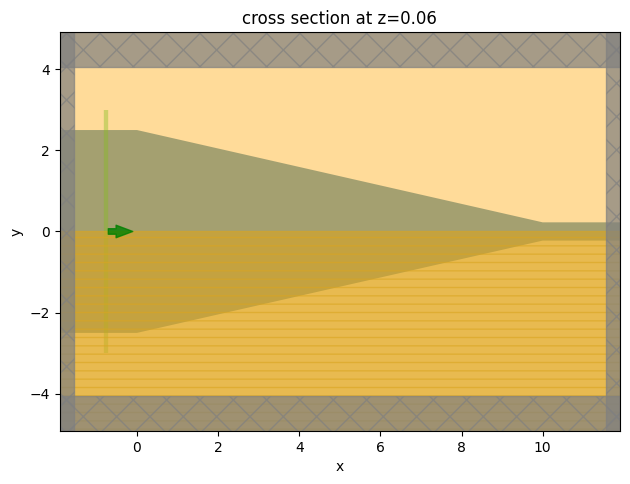

In [6]:
sim.plot(z=t_wg/2)
plt.show()

Submit the simulation.

In [7]:
sim_data = web.run(simulation=sim, task_name="taper", path="data/simulation_data.hdf5")

[15:21:00] Created task 'taper' with task_id 'fdve-36f853ad-86d4-4669-9924-eb0db68748adv1'.           ]8;id=621941;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=373138;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#139\139]8;;\

           View task using web UI at                                                                  ]8;id=678876;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=210251;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#141\141]8;;\
           ]8;id=994376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36f853ad-86d4-4669-9924-eb0db68748adv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=375225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36f853ad-86d4-4669-9924-eb0db68748adv1\taskId]8;;\]8;id=994376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36f853ad-86d4-4669-9924-eb0db68748adv1\=]8;;\]8;id=570662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36f853ad-86d4-4669-9924-eb0db68748adv1\fdve]8;;\]8;id=994376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36f853ad-86d4-4669-9924-eb0db68748adv1\-36f853ad-86d4-4669-9924-eb0db68748a]8;;\              
           ]8;id=994376;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36f853ad-86d4-4669-9924-eb0db68748adv1\dv1']8;;\.                                                                                                   

Output()

[15:21:02] status = queued                                                                            ]8;id=370370;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=171507;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#271\271]8;;\

Output()

[15:21:05] status = preprocess                                                                        ]8;id=210932;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=49009;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#265\265]8;;\

[15:21:09] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=888031;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=922816;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=279667;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=637073;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#292\292]8;;\

[15:21:10] running solver                                                                             ]8;id=952268;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=154415;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#302\302]8;;\

Output()

[15:21:22] early shutoff detected, exiting.                                                           ]8;id=168094;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=255889;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#316\316]8;;\

[15:21:23] status = postprocess                                                                       ]8;id=312937;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=658331;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#333\333]8;;\

Output()

[15:21:26] status = success                                                                           ]8;id=132306;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=468592;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#340\340]8;;\

Output()

[15:21:27] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=667161;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=886100;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#512\512]8;;\

## Creating Animation 

Before creating the animation, we can inspect the field distribution at a few time instances.

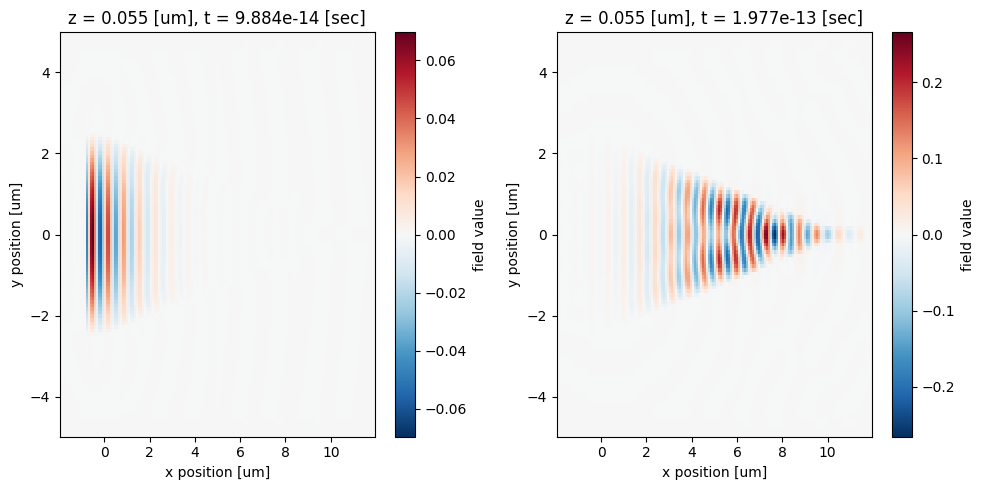

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5), tight_layout=True)

sim_data['movie_monitor'].Hz.sel(t=1e-13, method='nearest').plot(x='x', y='y', ax=ax[0])

sim_data['movie_monitor'].Hz.sel(t=2e-13, method='nearest').plot(x='x', y='y', ax=ax[1])
plt.show()

To create an animation, we need to define a function that plots each frame. Then we use `matplotlib`'s `FuncAnimation` to create the animation. For this particular animation, we use 50 frames. For detail on `FuncAnimation`, please reference the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html).

After the animation is created, we can display it directly in the notebook environment by using `HTML`. Here we see the incident pulse from the wider waveguide is squeezed into the narrower waveguide through the taper. Some field is reflected back or leaked out of the waveguide, leading to some insertion loss, which can be minimized by using a longer taper. 

In [9]:
t_end = sim_data['movie_monitor'].Hz.coords['t'][-1]  # end time of the animation
frames = 50  # number of frames

fig, ax = plt.subplots()

def animate(i):
    t = t_end*i/frames # time at each frame
    sim_data['movie_monitor'].Hz.sel(t=t, method='nearest').plot(x='x', y='y', ax=ax, vmin=-0.1, vmax=0.1, add_colorbar=False, cmap='seismic')

# create animation
ani = animation.FuncAnimation(fig, animate, frames=frames);
plt.close()

# display the animation
HTML(ani.to_jshtml())
